<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Some-general-parameters" data-toc-modified-id="Some-general-parameters-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Some general parameters</a></span></li></ul></li><li><span><a href="#Working-example-of-recall-with-z-traces" data-toc-modified-id="Working-example-of-recall-with-z-traces-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Working example of recall with z-traces</a></span></li></ul></div>

# Preamble

In [3]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns



from network import Protocol, Network, NetworkManager
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## Functions

## Some general parameters

In [55]:
%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

epsilon = 1e-7
vmin = -6.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 0.5
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

# Working example of recall with z-traces

In [56]:
%%time

sigma_out = 0.0
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 4
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['o', 'i', 'z_pre', 's']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.1 ms


pattern sequence [0, 1, 2, 3]
times [0.096, 0.105, 0.105, 0.116]
T_calculated 0.105


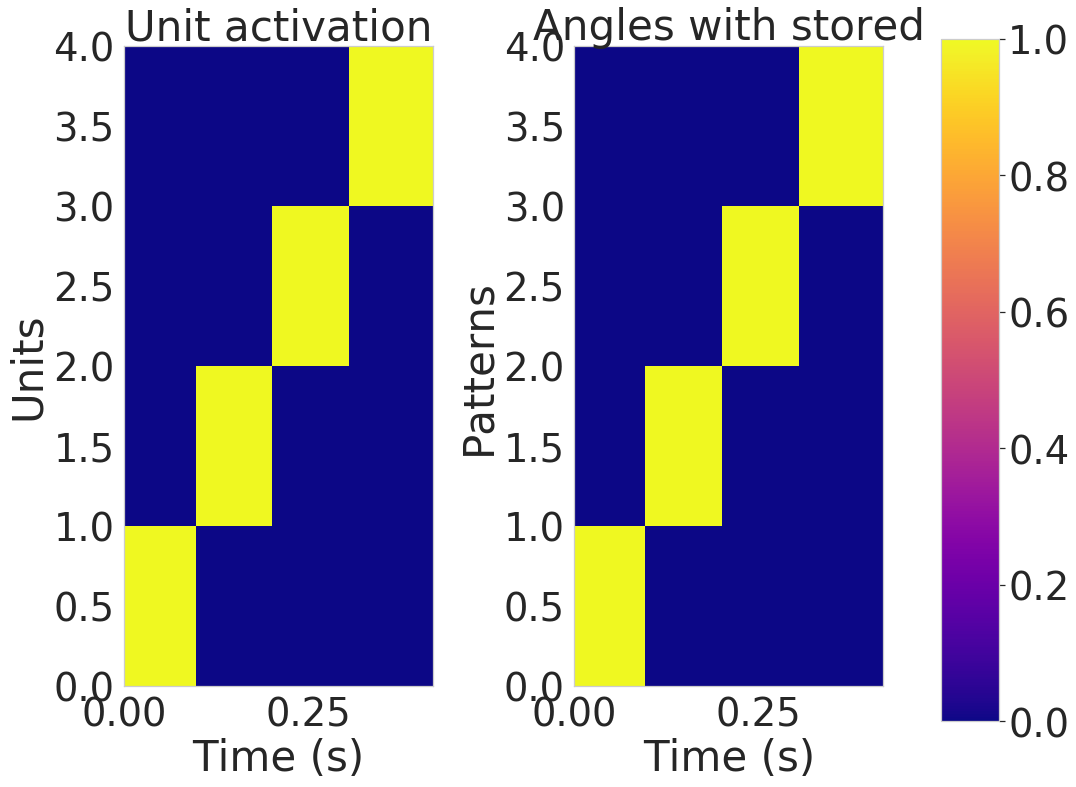

In [57]:
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

T_cue = 1.0 * manager.nn.tau_s
T_recall = 1.0 * T_persistence * n_patterns + T_cue

# Success
nr = representation.network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux

print('pattern sequence', pattern_sequence)
print('times', persistent_times)
print('T_calculated', np.mean(persistent_times[1:-1]))
plot_network_activity_angle(manager, time_y=False);

(-4.0, 1.0)

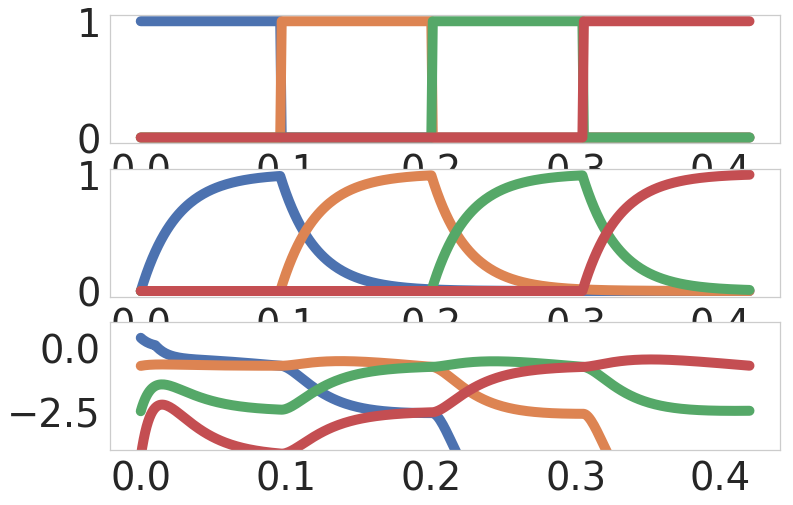

In [58]:
I = manager.history['i']
O = manager.history['o']
Z_pre = manager.history['z_pre']
S = manager.history['s']

fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

for o in O.T:
    ax1.plot(manager.time, o, lw=lw)
    
for z in Z_pre.T:
    ax2.plot(manager.time, z, lw=lw)
    
for current in S.T:
    ax3.plot(manager.time, current, lw=lw)

ax3.set_ylim([-4.0, 1.0])

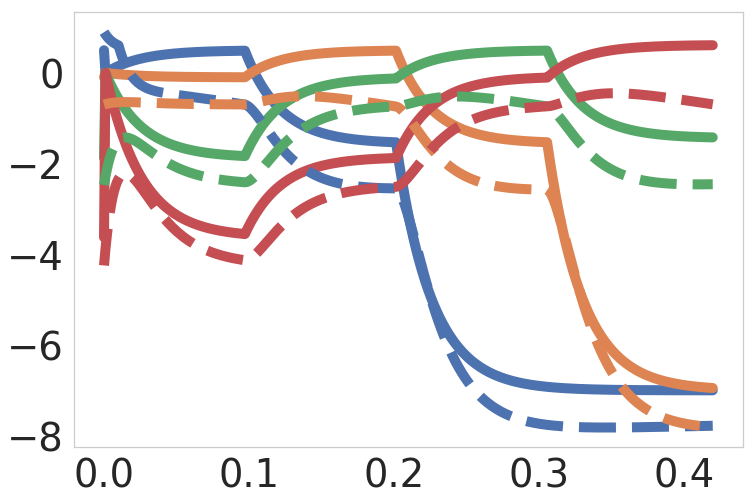

In [49]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for index, current in enumerate(I.T):
    ax1.plot(manager.time, current, lw=lw, color=colors[index])
for index, s in enumerate(S.T):
    ax1.plot(manager.time, s, ls='--', lw=lw, color=colors[index])

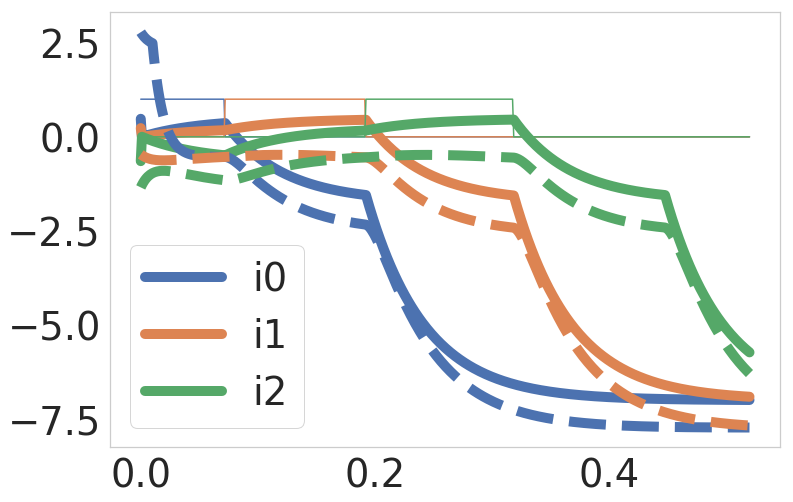

In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for index, current in enumerate(I.T):
    if index < 3:
        ax1.plot(manager.time, O[:, index], color=colors[index])
        ax1.plot(manager.time, current, lw=lw, color=colors[index], label='i' +str(index))
for index, s in enumerate(S.T):
    if index < 3:
        ax1.plot(manager.time, s, ls='--', lw=lw, color=colors[index])
        
ax1.legend()

The dotted line is the total current (forward current plus bias minus adaptation). The first total current starts decreasing even if the self-excitatory current starts increasing and also the forward current to the second unit (orange) starts growing. When the second unit becomes activated keeps growing faster than it decays (because the time constant of the z-filter is faster than the adaptation but that gives up at some point. Note that the total currents s are very close among them.



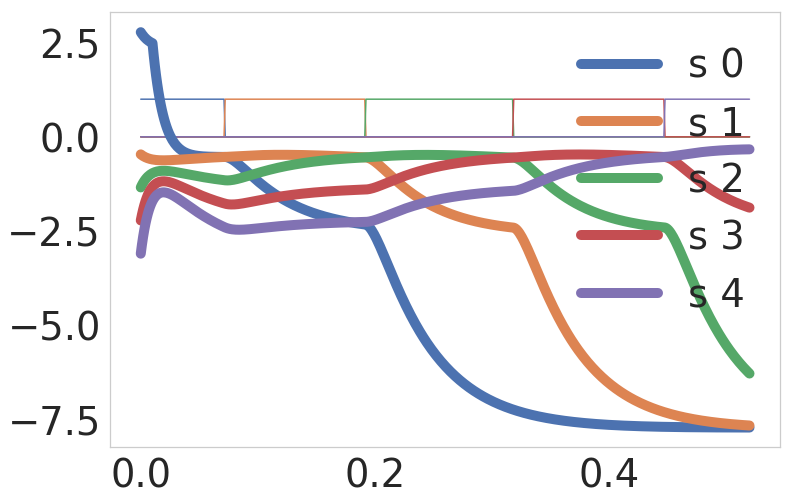

In [29]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for index, current in enumerate(I.T):
    if index < 5:
        ax1.plot(manager.time, O[:, index], color=colors[index])
for index, s in enumerate(S.T):
    if index < 5:
        ax1.plot(manager.time, s, ls='-', lw=lw, color=colors[index], label='s '+str(index))
        
ax1.legend(frameon=False)